Here, we fit lightgbm

In [2]:
library(tidyverse)
library(lightgbm)

# load gdd data
gdd_data <- read.csv("../A_outputs/A41_gdd_kyoto.csv")

head(gdd_data)
dim(gdd_data)

,name,date,id,tmax,tmin,prcp,year,month,day,daily_Cd,daily_Ca,Cd_cumsum,Ca_cumsum,lat,long,alt,bloom_doy,is_bloom
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,NAGOYA,1951-03-01,JA000047636,16.2,6.7,20.1,1951,3,1,-0.150000,4.60,-131.2953,80.20,35.16778,136.9656,51.1,NA,0
2,NAGOYA,1951-03-02,JA000047636,9.3,1.7,0.0,1951,3,2,-2.650000,1.15,-133.9453,81.35,35.16778,136.9656,51.1,NA,0
3,NAGOYA,1951-03-03,JA000047636,6.5,-1.9,0.0,1951,3,3,-2.514881,0.00,-136.4602,81.35,35.16778,136.9656,51.1,NA,0
4,NAGOYA,1951-03-04,JA000047636,6.0,-2.4,0.0,1951,3,4,-2.142857,0.00,-138.6030,81.35,35.16778,136.9656,51.1,NA,0
5,NAGOYA,1951-03-05,JA000047636,8.8,-2.7,0.0,1951,3,5,-2.466957,0.90,-141.0700,82.25,35.16778,136.9656,51.1,NA,0
6,NAGOYA,1951-03-06,JA000047636,14.0,0.7,33.6,1951,3,6,-3.150000,3.50,-144.2200,85.75,35.16778,136.9656,51.1,NA,0


[1] 37272    18

In [3]:
# number of samples with is_bloom == 1
table(gdd_data$is_bloom)

# The data is highly unbalanced. Therefore, we try to balance it by randomly sampling rows with is_bloom == 0 to match the size to the is_bloom == 1.
is_bloom_df <- gdd_data[gdd_data$is_bloom == 1, ]
no_bloom_df <- gdd_data[gdd_data$is_bloom == 0, ]

set.seed(42)
idx <- sample(1:nrow(no_bloom_df), size = ceiling(1.5*nrow(is_bloom_df)), replace = FALSE)
no_bloom_sample <- no_bloom_df[idx, ]

new_bloom_df <- rbind(is_bloom_df, no_bloom_sample)
shuffle_new <- new_bloom_df[sample(1:nrow(new_bloom_df), size = nrow(new_bloom_df), replace = FALSE), ] %>%
    'rownames<-'(NULL) %>%
    select(-name, -date, -id, -bloom_doy)

head(shuffle_new)
dim(shuffle_new)
table(shuffle_new$is_bloom)


    0     1 
36914   358 

,tmax,tmin,prcp,year,month,day,daily_Cd,daily_Ca,Cd_cumsum,Ca_cumsum,lat,long,alt,is_bloom
,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,10.0,6.5,3.5,1970,4,2,-0.25,1.50,-207.3796,132.85,34.74944,139.3631,74.00,0
2,12.3,5.2,0.0,2010,3,27,-0.90,2.65,-273.3145,239.40,34.98694,139.8653,5.80,0
3,19.8,8.6,0.0,1995,4,6,0.00,7.20,-276.9162,228.80,35.16778,136.9656,51.10,1
4,17.7,7.5,0.0,1978,4,25,0.00,5.60,-198.8309,314.05,34.89667,132.0706,19.00,0
5,16.1,5.6,0.0,1997,4,1,-0.70,4.55,-229.1288,270.40,34.75389,137.7117,45.93,1
6,10.5,5.4,0.1,1965,4,11,-0.80,1.75,-239.9008,153.05,34.89667,132.0706,19.00,1


[1] 895  14


  0   1 
537 358 

In [13]:
# split a test set
test_set <- shuffle_new %>% filter(year %in% 2012:2023) %>% select(-year)
dim(test_set)
train_val_set <- shuffle_new %>% filter(year < 2012) %>% select(-year)
dim(train_val_set)

write.csv(train_val_set, "../B_outputs/B11_japan_train_val.csv", row.names = FALSE, quote = FALSE)
write.csv(test_set, "../B_outputs/B11_japan_test.csv", row.names = FALSE, quote = FALSE)

[1] 110  13

[1] 785  13

In [14]:
head(train_val_set)

,tmax,tmin,prcp,month,day,daily_Cd,daily_Ca,Cd_cumsum,Ca_cumsum,lat,long,alt,is_bloom
,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,10.0,6.5,3.5,4,2,-0.25,1.50,-207.3796,132.85,34.74944,139.3631,74.00,0
2,12.3,5.2,0.0,3,27,-0.90,2.65,-273.3145,239.40,34.98694,139.8653,5.80,0
3,19.8,8.6,0.0,4,6,0.00,7.20,-276.9162,228.80,35.16778,136.9656,51.10,1
4,17.7,7.5,0.0,4,25,0.00,5.60,-198.8309,314.05,34.89667,132.0706,19.00,0
5,16.1,5.6,0.0,4,1,-0.70,4.55,-229.1288,270.40,34.75389,137.7117,45.93,1
6,10.5,5.4,0.1,4,11,-0.80,1.75,-239.9008,153.05,34.89667,132.0706,19.00,1


In [1]:
# Fit lightgbm

# 1. split dataset into train and test set.
# - Here, we leave out the last 10 years data (2013-2022) as our test set.
# - We're using 5-fold cross-validation. Therefore, split the groups into 5.
# - First, split the response variable data for a semi-stratified sampling.

library(tidyverse)
library(lightgbm)

train_val_set <- read.csv("../B_outputs/B11_japan_train_val.csv")

lgb_df <- train_val_set

set.seed(1)
gdd_bloom <- lgb_df[lgb_df$is_bloom == 1, ]
cv_group_bloom <- sample(1:5, size = nrow(gdd_bloom), replace = TRUE)
gdd_bloom$cv_group <- cv_group_bloom

gdd_nobloom <- lgb_df[lgb_df$is_bloom == 0, ]
cv_group_nobloom <- sample(1:5, size = nrow(gdd_nobloom), replace = TRUE)
gdd_nobloom$cv_group <- cv_group_nobloom

lgb_df2 <- rbind(gdd_bloom, gdd_nobloom)

# - train, test split
gdd_train <- lgb_df2[lgb_df2$cv_group != 1, ] %>% dplyr::select(-cv_group)
gdd_val <- lgb_df2[lgb_df2$cv_group == 1, ] %>% dplyr::select(-cv_group)

# - split X and y
library(Matrix)
# gdd_train_X <- gdd_train %>% dplyr::select(-is_bloom)
gdd_train_X <- sparse.model.matrix(is_bloom ~., data = gdd_train)
gdd_train_y <- gdd_train[, "is_bloom"]

# gdd_val_X <- gdd_val %>% dplyr::select(-is_bloom)
gdd_val_X <- sparse.model.matrix(is_bloom ~., data = gdd_val)
gdd_val_y <- gdd_val[, "is_bloom"]

# 2. Create lgb.Dataset objects
dtrain <- lgb.Dataset(data = as.matrix(gdd_train_X), label = gdd_train_y)
dval <- lgb.Dataset(data = as.matrix(gdd_val_X), label = gdd_val_y)

# 3. Build model
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
# Use focal loss? - https://towardsdatascience.com/lightgbm-with-the-focal-loss-for-imbalanced-datasets-9836a9ae00ca
# Use doy as the reponse? - make it a regression problem.
# Pull info from other Japanese cities with similar latitude, and then randomly sample 2*positive cases.
neg_pos_ratio <- sum(gdd_train$is_bloom == 0) / sum(gdd_train$is_bloom == 01)

params <- list(
    objective = "binary",
    metric = "binary_logloss",
    # feature_pre_filter = FALSE, # only necessary when reducing min_data_in_leaf
    min_data_in_leaf = 30, # default: 20
    # max_depth = -1,
    # scale_pos_weight = neg_pos_ratio,
    # data_sampling_strategy = "bagging", # options: "bagging", "goss"
    # pos_bagging_fraction = 0.5,
    # neg_bagging_fraction = 0.01,
    monotone_constraints_method = "advanced", # options: "basic", "intermediate", "advanced"
    learning_rate = 0.001,
    # max_bin = 10, # default: 255
    # is_enable_sparse = TRUE,
    # n_estimators = 1000,
    num_leaves = 2000
)

valids <- list(test = dval)

lgb_model <- lgb.train(params = params, data = dtrain, nrounds = 1000, valids, verbose = -1)

# 4. Accuracy checking
library(caret)
p <- predict(lgb_model, gdd_val_X)
gdd_val <- gdd_val
gdd_val$predicted <- ifelse(p > 0.5, 1, 0)
dim(gdd_val_X)
confusionMatrix(factor(gdd_val$predicted), factor(gdd_val$is_bloom))


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: R6


Attaching package: ‘lightgbm’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




[1] 157  13

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 69 16
         1 14 58
                                          
               Accuracy : 0.8089          
                 95% CI : (0.7386, 0.8672)
    No Information Rate : 0.5287          
    P-Value [Acc > NIR] : 2.191e-13       
                                          
                  Kappa : 0.616           
                                          
 Mcnemar's Test P-Value : 0.8551          
                                          
            Sensitivity : 0.8313          
            Specificity : 0.7838          
         Pos Pred Value : 0.8118          
         Neg Pred Value : 0.8056          
             Prevalence : 0.5287          
         Detection Rate : 0.4395          
   Detection Prevalence : 0.5414          
      Balanced Accuracy : 0.8076          
                                          
       'Positive' Class : 0               
                                    

In [ ]:
# Evaluation curve
# pred <- prediction(p, gdd_val$is_bloom)
# eval <- performance(pred, "acc")
# plot(eval)

# #ROC
# roc = performance(pred, "tpr", "fpr")
# plot(roc, main = "ROC curve")
# abline(a = 0, b = 1)

In [11]:
?lgb.plot.importance

lgb.plot.importance          package:lightgbm          R Documentation

_P_l_o_t _f_e_a_t_u_r_e _i_m_p_o_r_t_a_n_c_e _a_s _a _b_a_r _g_r_a_p_h

_D_e_s_c_r_i_p_t_i_o_n:

     Plot previously calculated feature importance: Gain, Cover and
     Frequency, as a bar graph.

_U_s_a_g_e:

     lgb.plot.importance(
       tree_imp,
       top_n = 10L,
       measure = "Gain",
       left_margin = 10L,
       cex = NULL
     )
     
_A_r_g_u_m_e_n_t_s:

tree_imp: a ‘data.table’ returned by ‘lgb.importance’.

   top_n: maximal number of top features to include into the plot.

 measure: the name of importance measure to plot, can be "Gain",
          "Cover" or "Frequency".

left_margin: (base R barplot) allows to adjust the left margin size to
          fit feature names.

     cex: (base R barplot) passed as ‘cex.names’ parameter to
          ‘barplot’. Set a number smaller than 1.0 to make the bar
          labels smaller than R's defaul

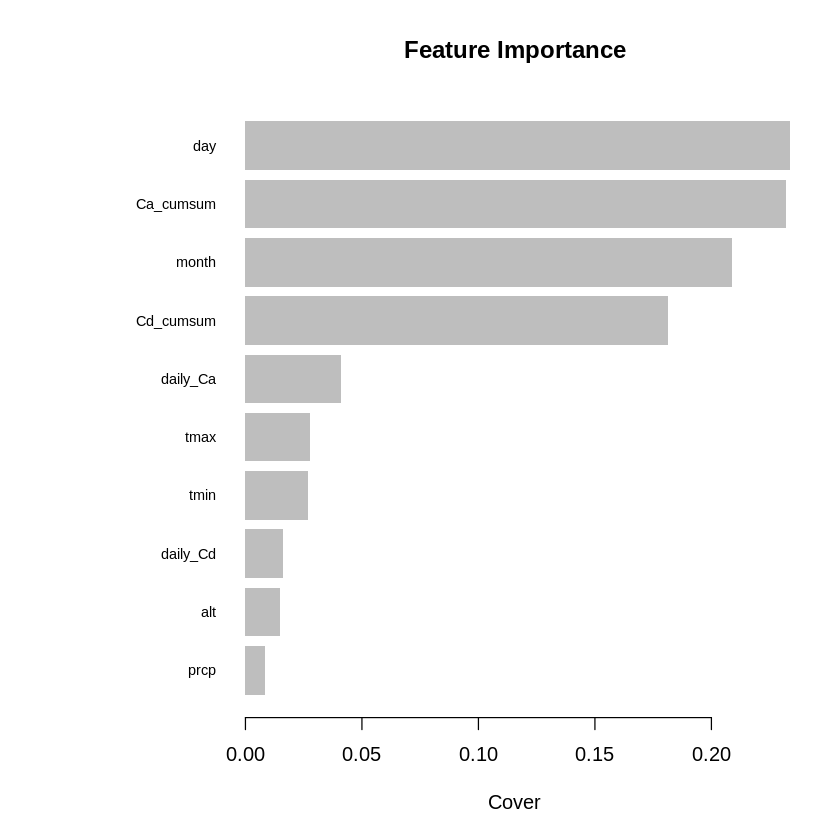

: 

In [2]:
# 5. Feature importance
tree_imp <- lgb.importance(lgb_model, percentage = TRUE)
lgb.plot.importance(tree_imp, top_n = 10L, measure = "Cover") # options: "Gain", "Cover", "Frequency"

In [34]:
?confusionMatrix

No documentation for ‘confusionMatrix’ in specified packages and libraries:
you could try ‘??confusionMatrix’